# Sentiment analysis

The third methods used to answer the research questions are transformers for text classification. Transformers are a relatively new technology in the NLP field and enable analyses that were not so easily possible before {cite:p}`atteveldt_computational_2022`. At the same time, they can perform analyses such as sentiment analysis much better and more precisely than it would be possible with a dictionary-based approach, for example {cite:p}`vaswani_attention`. The key component of transformers is the self-attention mechanism, which allows the model to weight different parts of a sequence dynamically, rather than relying on a fixed window size as in traditional RNNs or CNNs {cite:p}`vaswani_attention`. We are going to use a transfoer to analyse the sentiment of the comments.

For this project the Hugging Face library is used, which provides pretrained state of th art models for many different application areas. Will we use a BERT based model that was trained on 1.8 million German-language samples {cite:p}`german_sentiment` to perform sentiment analysis. The model has three labels for the sentiment: positive, neutral and negative.

In [ ]:
import pandas as pd
from tqdm import tqdm
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from cleantext import clean

One advantage of transformers is that they usually require little preprocessing. After loading the comments, the emojis are removed from the comments first. In addition, all URLs and mentions are removed, as it is very unlikely that the model can do anything with this information. At the end, as in previous analyses, empty comments are removed.

In [9]:
comments_df = pd.read_csv("data/youtube_comments_500.csv")
comments_df["Comments"] = comments_df["Comments"].astype(str)

def clean_text(text:str):
    text = clean(text, no_emoji=True, lang="de")
    new_text = []
    for token in text.split(" "):
        if not token.startswith('@') and not token.startswith('http'):
            new_text.append(token)
    return " ".join(new_text)

comments_df["Comments"] = comments_df["Comments"].apply(lambda text: clean_text(text))
comments_df =comments_df[comments_df.Comments != ""]
display(comments_df)

,Unnamed: 0,Comments
0,0,wollt ihr jetzt jeden tag einen großen bericht...
1,1,"wenn scholz alles besser weiss, wieso braucht ..."
2,2,die grünen hatten früher das peace zeichen als...
3,3,der westen ist ein kriegstreiber bis es zu ein...
4,4,frieden schaffen ohne waffen.
...,...,...
406237,406237,"kann jeder deutscher werden ,kein problem sola..."
406238,406238,dann nimm die leute bei dir auf und verpflege ...
406239,406239,als staatenloser hatt mans aber auch nicht lei...
406240,406240,wann kommt der blackout? kinder könnt ihr ja e...


To start the sentiment analysis, the pretrained model is loaded together with the corrsponding tokenizer and model configuration. Then each comment is processed sequentially. First the input is tokenized and then passed to the model. The output of the model contains logits and is therefore converted into probabilities using the softmax function. Then the output is converted from a tensor into a numpy array in order to extract the label with with highest proability in the next step. To get the label with the highest proability the output list is first sorted. The numpy function argsort is used to sort the list and to get the index (and not the sorted values). Then the order of the sorting is reversed (`[::-1]`) and the first element is selected so that the index of the label with the highest probability is obtained. The corresponding confidence value is also stored. At the end all results are added to the dataframe and saved. When looking at the first lines of the dataframe, it can be seen that everything has worked.

In [ ]:
model_name = "oliverguhr/german-sentiment-bert"
sentiment_tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model_config = AutoConfig.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name)

label_list = []
score_list = []

for text in tqdm(comments_df.Comments.to_list()):
    tokenized_input = sentiment_tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)
    output = sentiment_model(**tokenized_input)
    predictions = torch.nn.functional.softmax(output.logits, dim=-1)
    predictions = predictions.detach().numpy()[0]
    label_list.append(sentiment_model_config.id2label[np.argsort(predictions)[::-1][0]])
    score_list.append(max(predictions))

comments_df["sentiment"] = label_list
comments_df["sentiment_score"] = score_list
comments_df.to_csv("data/sentiments.csv", index=False)

In [5]:
comments = pd.read_csv("data/sentiments.csv")
comments.head(10)

,Unnamed: 0,Comments,sentiment,sentiment_score
0,0,wollt ihr jetzt jeden tag einen großen bericht...,negative,0.997865
1,1,"wenn scholz alles besser weiss, wieso braucht ...",neutral,0.966083
2,2,die grünen hatten früher das peace zeichen als...,negative,0.984363
3,3,der westen ist ein kriegstreiber bis es zu ein...,neutral,0.998064
4,4,frieden schaffen ohne waffen.,neutral,0.995086
5,5,"donnor, dann sag putin, er soll aus der ukrain...",neutral,0.998752
6,6,"kanal sahra wagenknecht: erst panzer, dann kam...",negative,0.938369
7,7,"donnor, beweis deine behauptung, die ukraine w...",negative,0.985598
8,8,deutschland wird mit der lieferung nichts gute...,neutral,0.991995
9,9,warum? frieden schaffen mit waffen. denk mal a...,neutral,0.877570


The results can now be visualised with the help of a bar chart. It can be seen that most comments are negative (49%), followed by neutral comments (42%). With 8%, only very few comments are positive. It can be concluded from this that the overall sentiment in the comments section is clearly negative.

(0.0, 0.65)

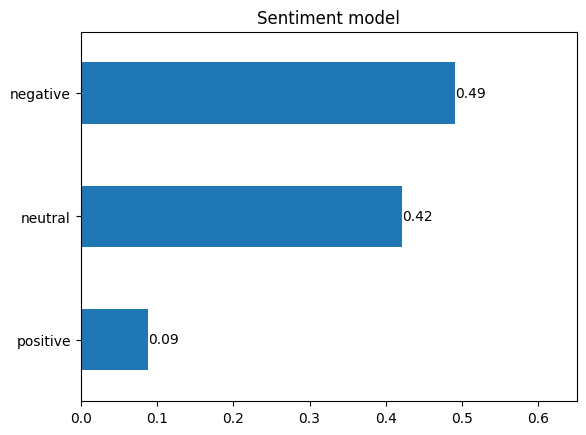

In [8]:
ax = comments["sentiment"].value_counts(normalize=True).sort_values().plot(kind="barh", title="Sentiment model")
ax.bar_label(ax.containers[0], fmt="%.2f")
ax.set_xlim(0,0.65)